# Scenario Object Tutorial
---

This is a quick tutorial to guide the user through the functionalities of the *Scenario* object. The object has several internal state. So far the **create**, **execute**, **analyze** and **delete** states have been implemented.  Only one argument is required to instantiate a *Scenario* object: the `descriptor` (type `str`) of the scenario, which can either be the scenario id or name. Depending on the descriptor passed, the *Scenario* object will take different state:
* empty string --> **create** state;
* valid scenario id or name --> **analyze** state is activated if the simulation has been successfully ran and the output data have been extracted. Otherwise the state will be set to **execute**.

The architecture of the *Scenario* object is shown below.
![Scenario Workflow](scenario.jpg)

## Analyzing Scenario
Let's see what happens when the scenario name or id passed as argument is not found in the scenario list file on the server.

In [1]:
from powersimdata.scenario.scenario import Scenario

In [2]:
scenario = Scenario('dummy')

------------------
SCENARIO NOT FOUND
------------------
 id      plan            name        interconnect base_demand base_hydro base_solar base_wind
 0   base          original           Western      v3          v1         v2         v1      
 1   ca2045        ca2020             Western      ca2020      v1         v2         v1      
 2   ca2045        ca2020FixCaCong    Western      ca2020      v1         v2         v1      
 3   ca2045        ca2020FixWestCong  Western      ca2020      v1         v2         v1      
 4   ca2045        ca2020WestTarget   Western      ca2020      v1         v2         v1      
 5   ca2045        ca2030             Western      ca2030      v1         v2         v1      
 6   ca2045        ca2030FixCaCong    Western      ca2030      v1         v2         v1      
 7   ca2045        ca2030FixWestCong  Western      ca2030      v1         v2         v1      
 8   ca2045        ca2030WestTarget   Western      ca2030      v1         v2         v1      
 9 

It prints the list of available scenarios. Note that the scenario **id** is unique while the scenario **name** is only unique for a given plan - interconnect combination. If there are multiple scenario sharing the same name in the scenario list file then the above summary will be returned and the user will be asked to provide the identification number in order to select a scenario.

Let's now pick a scenario that exists.

In [3]:
scenario = Scenario('3')

SCENARIO: ca2045 | ca2020FixWestCong

--> State
analyze
--> Loading ct
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


This *Scenario* object is in the **analyze** state. Note that it is possible to switch state. The **delete** state is accessible. This state will be used at the end of the notebook.

In [4]:
print("State name: %s" % scenario.state.name)
print("Allowed state: %s" % scenario.state.allowed)

State name: analyze
Allowed state: ['delete']


The description of the scenario can easily be accessed.

In [5]:
scenario.print_scenario_info()

--------------------
SCENARIO INFORMATION
--------------------
id: 3
plan: ca2045
name: ca2020FixWestCong
state: analyze
interconnect: Western
base_demand: ca2020
base_hydro: v1
base_solar: v2
base_wind: v1
change_table: Yes
start_date: 2016-01-01 00:00:00
end_date: 2016-12-31 23:00:00
interval: 144H
runtime: 9:08
infeasibilities: 34:5_35:5


When a *Scenario* object is created, the change table and grid are automatically loaded. Changes found in the change table are applied to the grid. This means that the capacity of some generators and/or transmission lines will be modified. The grid used for this scenario can be accessed as follows:

In [6]:
grid = scenario.state.get_grid()
grid.plant.head(n=10)

,bus_id,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin,...,mu_Qmax,mu_Qmin,GenMWMax,GenMWMin,type,interconnect,lat,lon,zone_id,zone_name
plant_id,,,,,,,,,,,,,,,,,,,,,
10390,2010683,0.00,0.00,61.16,-7.80,1.0464,207.74,0,159.27,52.01,...,0.0,0.0,159.270000,52.010000,hydro,Western,46.6451,-119.9080,201,Washington
10391,2010684,85.29,56.74,61.16,-7.80,1.0201,201.13,1,85.29,85.29,...,0.0,0.0,159.266663,32.410946,hydro,Western,46.6451,-119.9080,201,Washington
10392,2010685,138.65,56.74,61.16,-7.80,1.0201,217.36,1,138.65,138.65,...,0.0,0.0,159.266663,56.056601,hydro,Western,46.6451,-119.9080,201,Washington
10393,2010686,0.00,0.00,61.16,-7.80,1.0464,214.15,0,159.27,56.04,...,0.0,0.0,159.266663,56.038070,hydro,Western,46.6451,-119.9080,201,Washington
10394,2010687,120.63,56.74,61.16,-7.80,1.0188,188.08,1,120.63,120.63,...,0.0,0.0,159.266663,39.988425,hydro,Western,46.6451,-119.9080,201,Washington
10395,2010688,109.93,56.74,61.16,-7.80,1.0206,201.28,1,109.93,109.93,...,0.0,0.0,159.266663,19.930100,hydro,Western,46.6451,-119.9080,201,Washington
10396,2010689,9.02,4.95,4.95,-0.63,1.0014,12.90,1,9.02,9.02,...,0.0,0.0,12.899999,1.998092,hydro,Western,46.6451,-119.9080,201,Washington
10397,2010691,59.72,21.07,21.07,-14.24,1.0061,98.92,1,59.72,59.72,...,0.0,0.0,98.900002,16.648942,wind,Western,45.8131,-120.3475,201,Washington
10398,2010694,23.02,5.33,13.44,-1.71,1.0493,35.08,1,23.02,23.02,...,0.0,0.0,34.999999,3.838867,hydro,Western,46.4661,-122.1097,201,Washington


And the change table:

In [7]:
ct = scenario.state.get_ct()
print(ct)

{'solar': {'zone_id': {203: 1.52, 204: 1.52, 205: 1.52, 206: 1.52, 207: 1.52}}, 'wind': {'zone_id': {203: 1.48, 204: 1.48, 206: 1.48, 207: 1.48}}, 'branch': {'branch_id': {88258: 2, 88270: 2, 89167: 2, 89181: 2, 89240: 2, 89242: 2, 89335: 2, 89339: 2, 89756: 2, 90143: 2, 90240: 2, 90323: 2, 90349: 2, 90350: 2, 90353: 2, 90373: 2, 90395: 2, 90415: 2, 90630: 2, 90696: 2, 91031: 2, 91117: 2, 91161: 2, 91770: 2, 91965: 2, 92043: 2, 92103: 2, 92675: 2, 92676: 2, 93157: 2, 93215: 2, 93280: 2, 93525: 2, 93812: 2, 93887: 2, 93929: 2, 93932: 2, 94027: 2, 94030: 2, 94032: 2, 94046: 2, 94065: 2, 94068: 2, 94095: 2, 94102: 2, 94137: 2, 94140: 2, 94222: 2, 94224: 2, 94225: 2, 94226: 2, 94323: 2, 94342: 2, 94481: 2, 94529: 2, 94549: 2, 94820: 2, 95277: 2, 95316: 2, 95407: 2, 95414: 2, 95474: 2, 95501: 2, 95521: 2, 95522: 2, 95594: 2, 95614: 2, 95629: 2, 95633: 2, 95773: 2, 95966: 2, 95971: 2, 95987: 2, 95991: 2, 95997: 2, 96009: 2, 96023: 2, 96162: 2, 96464: 2, 96938: 2, 96963: 2, 97059: 2, 97072: 2

One can sees that the capacity of solar and wind generators in load zones 203, 204, 205, 206 and 207 have been increased by 1.52 and 1.48, respectively. Also, the capacity of some transmission lines has been increased by a factor 2. In this case the branch id has been used. The mapping load zone id --> load zone name is accessible via the *Grid* object.

In [8]:
grid.id2zone

{201: 'Washington',
 202: 'Oregon',
 203: 'Northern California',
 204: 'Bay Area',
 205: 'Central California',
 206: 'Southwest California',
 207: 'Southeast California',
 208: 'Nevada',
 209: 'Arizona',
 210: 'Utah',
 211: 'New Mexico Western',
 212: 'Colorado',
 213: 'Wyoming',
 214: 'Idaho',
 215: 'Montana Western',
 216: 'El Paso'}

Those are the 16 load zones of the Western Interconnect. One can sees that only the solar and wind generators in California have been scaled. Let's take a look at the transmission lines in the change table:

In [9]:
grid.branch.loc[ct['branch']['branch_id'].keys()]

,from_bus_id,to_bus_id,r,x,b,rateA,rateB,rateC,ratio,angle,...,branch_device_type,interconnect,from_lat,from_lon,to_lat,to_lon,from_zone_id,to_zone_id,from_zone_name,to_zone_name
branch_id,,,,,,,,,,,,,,,,,,,,,
88258,2010033,2010045,0.010951,0.047533,0.03427,432.80,0,0,0.00000,0.0,...,Line,Western,46.127668,-123.010999,46.339390,-122.809116,201,201,Washington,Washington
88270,2010045,2010041,0.005713,0.037310,0.01199,236.56,0,0,0.00000,0.0,...,Line,Western,46.339390,-122.809116,46.418666,-122.895750,201,201,Washington,Washington
89167,2010690,2010691,0.003387,0.099890,0.00000,128.57,0,0,1.06250,0.0,...,Transformer,Western,45.813100,-120.347500,45.813100,-120.347500,201,201,Washington,Washington
89181,2010702,2010703,0.002458,0.078799,0.00000,177.19,0,0,1.00000,0.0,...,Transformer,Western,45.879700,-120.807200,45.879700,-120.807200,201,201,Washington,Washington
89240,2010862,2010740,0.001157,0.011576,0.68304,1129.14,0,0,0.00000,0.0,...,Line,Western,46.534700,-122.424700,46.060833,-122.201667,201,201,Washington,Washington
89242,2010745,2010746,0.003229,0.108939,0.00000,117.00,0,0,1.00000,0.0,...,Transformer,Western,46.954700,-120.181900,46.954700,-120.181900,201,201,Washington,Washington
89335,2010820,2010821,0.001925,0.061021,0.00000,196.56,0,0,1.00000,0.0,...,Transformer,Western,45.921500,-120.235500,45.921500,-120.235500,201,201,Washington,Washington
89339,2013591,2010823,0.004927,0.031697,0.04237,194.39,0,0,0.00000,0.0,...,Line,Western,45.716700,-120.200800,45.921500,-120.235500,202,201,Oregon,Washington
89756,2013100,2013198,0.006014,0.027242,0.09078,187.57,0,0,0.00000,0.0,...,Line,Western,44.759860,-123.098768,44.509368,-122.912774,202,202,Oregon,Oregon


Where do these lines start and end?

In [10]:
for line in ct['branch']['branch_id'].keys():
    print("#%d: %s --> %s" % (line, grid.branch.loc[line].from_zone_name, grid.branch.loc[line].to_zone_name))

#88258: Washington --> Washington
#88270: Washington --> Washington
#89167: Washington --> Washington
#89181: Washington --> Washington
#89240: Washington --> Washington
#89242: Washington --> Washington
#89335: Washington --> Washington
#89339: Oregon --> Washington
#89756: Oregon --> Oregon
#90143: Oregon --> Oregon
#90240: Oregon --> Oregon
#90323: Oregon --> Oregon
#90349: Oregon --> Oregon
#90350: Oregon --> Oregon
#90353: Oregon --> Oregon
#90373: Oregon --> Oregon
#90395: Oregon --> Oregon
#90415: Oregon --> Oregon
#90630: Northern California --> Northern California
#90696: Northern California --> Northern California
#91031: Northern California --> Northern California
#91117: Northern California --> Northern California
#91161: Northern California --> Northern California
#91770: Bay Area --> Bay Area
#91965: Bay Area --> Bay Area
#92043: Bay Area --> Bay Area
#92103: Bay Area --> Bay Area
#92675: Central California --> Central California
#92676: Central California --> Central Cal

Input profiles and output data can be loaded as follows. If the file is not found locally, then it will be downloaded from the server.

In [11]:
wind = scenario.state.get_wind()
wind.head(n=10)

--> Loading wind


,10397,10400,10401,10428,10442,10458,10463,10475,10522,10541,...,12781,12794,12795,12796,12810,12811,12821,12822,12851,12853
UTC,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,33.909546,48.626080,51.586488,23.288450,24.722452,2.797636,30.861675,39.982030,19.645964,25.497791,...,1.537407,104.988481,9.695788,9.595831,4.768569,5.298409,7.203523,7.203523,102.031051,187.616487
2016-01-01 01:00:00,44.784148,36.054589,57.629619,18.203596,13.542212,6.911965,39.535177,39.244850,18.829837,31.653611,...,3.845821,106.481712,9.696933,9.596964,8.460214,9.400238,8.365460,8.365460,103.482219,188.972294
2016-01-01 02:00:00,40.734996,18.561881,52.191783,20.425524,16.816121,11.194243,39.297413,24.722842,16.544856,27.673932,...,3.740176,106.496834,9.698210,9.598228,8.983049,9.981165,9.284972,9.284972,103.496915,188.999999
2016-01-01 03:00:00,50.635387,20.275974,73.058373,29.439972,4.268782,10.527046,49.774332,43.521291,23.969048,32.047304,...,5.370021,106.500006,9.696742,9.596776,8.999180,9.999089,9.952833,9.952833,103.499997,188.999999
2016-01-01 04:00:00,53.228489,9.405172,84.871384,28.126471,0.725327,7.316950,55.562933,45.677556,27.052540,34.383732,...,9.226200,106.500006,9.666699,9.567042,8.980537,9.978374,9.972236,9.972236,103.499997,188.999999
2016-01-01 05:00:00,53.190699,21.428189,105.827933,31.319637,0.000000,7.191513,57.142437,44.205780,27.893860,36.189522,...,8.137596,106.500006,9.648035,9.548570,8.998466,9.998296,9.919974,9.919974,103.499997,188.999999
2016-01-01 06:00:00,55.095836,3.919431,23.580001,0.499303,14.604772,104.764732,0.000000,60.652748,0.077259,10.185377,...,13.024827,106.500006,9.697329,0.042406,8.717807,0.658001,0.377748,8.953696,90.712877,186.657566
2016-01-01 07:00:00,42.425082,19.660461,102.088990,15.474583,3.696718,13.950800,51.786974,23.712260,18.476934,35.471641,...,10.380569,106.500006,9.700000,9.600000,8.994836,9.994262,9.996891,9.996891,103.499997,188.999999
2016-01-01 08:00:00,33.334598,7.434749,90.665434,13.261137,9.221730,16.439985,43.057870,21.683408,15.181028,35.555042,...,9.227584,106.500006,9.699966,9.599966,8.996322,9.995913,9.998542,9.998542,103.499997,188.999999


Let's take a look at infeasibilities. These are period where demand were decreased by some amout in order to make the optimization problem solvable.

In [12]:
scenario.state.print_infeasibilities()

demand in 2016-07-23 00:00:00 - 2016-07-29 00:00:00 interval has been reduced by 5%
demand in 2016-07-29 00:00:00 - 2016-08-04 00:00:00 interval has been reduced by 5%


Below, we plot the original demand profile along with the reduced one for Washington State.

--> Loading demand
--> Loading demand


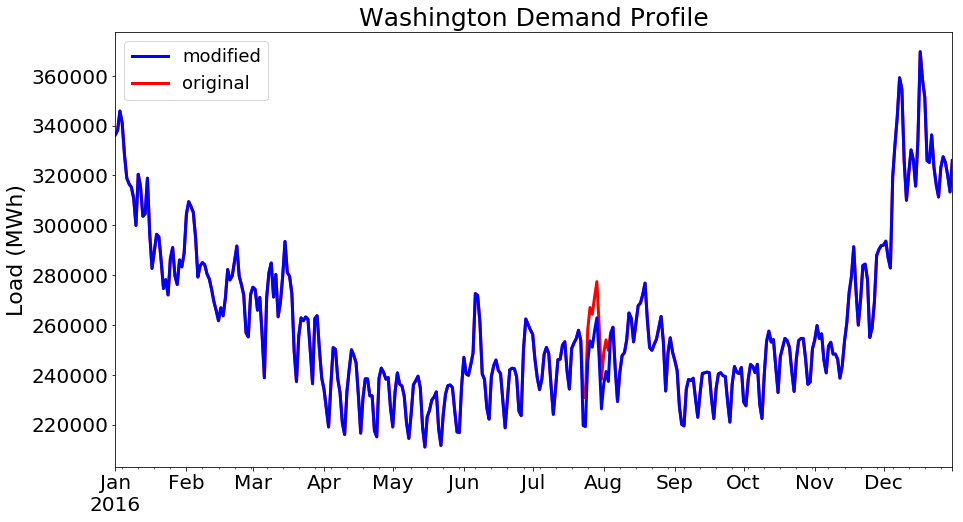

Original demand: 95246910 (MWh)
Reduced demand: 95093152 (MWh)


In [13]:
import matplotlib.pyplot as plt

zone = 201
demand_original = scenario.state.get_demand()
demand_modified = scenario.state.get_demand(original=False)

fig = plt.figure(figsize=(15, 8))
plt.title("%s Demand Profile" % grid.id2zone[201], fontsize=25)
ax = fig.gca()
ax.grid(color='black', axis='y')
ax.tick_params(which='both', labelsize=20)
ax = demand_original[zone].rename('original').resample('D').sum().plot(ax=ax, color='red', legend=True, lw=3)
ax = demand_modified[zone].rename('modified').resample('D').sum().plot(ax=ax, color='blue', legend=True, lw=3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=2, prop={'size': 18})
ax.set_xlabel('')
ax.set_ylabel('Load (MWh)', fontsize=22)
plt.show()

print("Original demand: %d (MWh)" % demand_original[201].sum())
print("Reduced demand: %d (MWh)" % demand_modified[zone].sum())

## Creating Scenario
Let's create a scenario now!

In [14]:
new_scenario = Scenario('')
print("State name: %s" % new_scenario.state.name)
print("Allowed state: %s" % new_scenario.state.allowed)

State name: create
Allowed state: []


In [15]:
new_scenario.print_scenario_info()

--------------------
SCENARIO INFORMATION
--------------------
plan: 
name: 
state: create
interconnect: 
base_demand: 
base_hydro: 
base_solar: 
base_wind: 
change_table: 
start_date: 
end_date: 
interval: 


To create a scenario, one needs to set all the above. Let's do so. First thing first, the interconnection (could be a list of interconnection).

In [16]:
new_scenario.state.set_builder(['Western'])

--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Summary
# Existing study
base | ca2045 | test_ben | test_scaling
# Available profiles
demand: ca2020 | ca2030 | v3 | v4
hydro: v1
solar: v2
wind: v1


The Western interconnection is loaded and the already existing plans for this interconnection are given. Also, a list of the available profiles for this particular interconnection is printed. Let's name our scenario.

In [17]:
new_scenario.state.builder.set_name('ca2045', 'ca2020')  # plan and scenario name

Exception: Combination ca2045 - ca2020 already exists

Oops, we can't do that. Let's pick a different name for our new scenario. Also, let's set the start date, end date and interval. Note that the interval size must satisfy the following condition: end date - start date (in hours) % interval (in hours) = 0

In [18]:
new_scenario.state.builder.set_name('test', 'dummy')
new_scenario.state.builder.set_time('2016-08-01 00:00:00', '2016-08-31 23:00:00', '124H')

Is that time to create the scenario?

In [19]:
new_scenario.state.create_scenario()

-------------------
MISSING INFORMATION
-------------------
base_demand
base_hydro
base_solar
base_wind


Nope. We still need to set the base profiles and eventually a change table.

In [20]:
new_scenario.state.builder.set_base_profile('demand', 'v3')
new_scenario.state.builder.set_base_profile('hydro', 'v1')
new_scenario.state.builder.set_base_profile('solar', 'v2')
new_scenario.state.builder.set_base_profile('wind', 'v1')

Also, let's increase the capacity of wind farms in Wisconsin.

In [21]:
new_scenario.state.builder.change_table.scale_plant_capacity('wind', {'Winsconsin': 5})

--------------
Possible zones
--------------
Washington
Oregon
Northern California
Bay Area
Central California
Southwest California
Southeast California
Nevada
Arizona
Utah
New Mexico Western
Colorado
Wyoming
Idaho
Montana Western
El Paso


Right, Wisconsin is not part of the Western interconnection. Let's try the following.

In [22]:
# scale capacity of solar plants in WA and AZ by 5 and 2.5, respectively
new_scenario.state.builder.change_table.scale_plant_capacity(
    'solar', zone_name={'Washington': 5, 'Arizona': 2.5})
# scale capacity of wind farms in OR and MT by 1.5 and 2, respectively
new_scenario.state.builder.change_table.scale_plant_capacity(
    'wind', zone_name={'Oregon': 1.5, 'Montana Western': 2})
# scale capacity of geothermal facilities in NV by 1.25
new_scenario.state.builder.change_table.scale_plant_capacity(
    'geothermal', zone_name={'Nevada': 1.25})
# scale capacity of transmission lines in NV and WY by 2
new_scenario.state.builder.change_table.scale_branch_capacity(zone_name={'Nevada': 2, 'Wyoming': 2})

print(new_scenario.state.builder.change_table.ct)  # print change table

{'solar': {'zone_id': {201: 5, 209: 2.5}}, 'wind': {'zone_id': {202: 1.5, 215: 2}}, 'geothermal': {'zone_id': {208: 1.25}}, 'branch': {'zone_id': {208: 2, 213: 2}}}


Let's review the scenario information now.

In [23]:
new_scenario.print_scenario_info()

--------------------
SCENARIO INFORMATION
--------------------
plan: test
name: dummy
state: create
interconnect: Western
base_demand: v3
base_hydro: v1
base_solar: v2
base_wind: v1
change_table: Yes
start_date: 2016-08-01 00:00:00
end_date: 2016-08-31 23:00:00
interval: 124H


Looks good. We can create the scenario now.

In [24]:
new_scenario.state.create_scenario()

CREATING SCENARIO: test | dummy 

--> Generating scenario id
--> Adding entry in scenario table on server
--> Writing change table on local machine
Writing /Users/brdo/ScenarioData/15_ct.pkl
--> Uploading change table to server
Transferring 15_ct.pkl to server
--> Creating links to base profiles on server
--> Adding entry in execute table on server

SCENARIO SUCCESSFULLY CREATED WITH ID #15
State switching: create --> execute


The scenario is created and a unique id is generated. Then, the `Scenario` object automatically switches state.

In [25]:
print("State name: %s" % new_scenario.state.name)
new_scenario.state.print_scenario_status()

State name: execute
---------------
SCENARIO STATUS
---------------
created


## Executing Scenario
We now execute the scenario we just created. it is a three steps process:
1. Prepare simulation inputs: scaled profiles and MATPOWER case file
2. Launch the simulation.
3. Extract data once the simulation is finished.

The status of the scenario can be checked anytime using the `print_scenario_status` method.

In [26]:
new_scenario.state.prepare_simulation_input()

---------------------------
PREPARING SIMULATION INPUTS
---------------------------
--> Loading ct
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Creating temporary folder on server for simulation inputs
--> Copying demand base profile into temporary folder


0.00b [00:00, ?b/s]

--> Copying hydro base profile into temporary folder
--> Loading solar
15_solar.csv not found in /Users/brdo/ScenarioData/ on local machine
Transferring 15_solar.csv from server


100%|##########| 37.4M/37.4M [00:02<00:00, 16.3Mb/s]


Writing scaled solar profile in /Users/brdo/ScenarioData/ on local machine
Transferring 15_solar.csv to server


  5%|4         | 1.64M/36.0M [00:00<00:02, 16.3Mb/s]

--> Loading wind
15_wind.csv not found in /Users/brdo/ScenarioData/ on local machine
Transferring 15_wind.csv from server


100%|##########| 36.0M/36.0M [00:01<00:00, 20.1Mb/s]


Writing scaled wind profile in /Users/brdo/ScenarioData/ on local machine
Transferring 15_wind.csv to server
--> Preparing MPC file
Scaling grid
Building MPC file
Transferring 15_case.mat to server
--> Updating status in execute table on server


Let's check the status of the scenario:

In [27]:
new_scenario.state.print_scenario_status()

---------------
SCENARIO STATUS
---------------
prepared


The scenario can then be launched using the `launch_simulation` method. A new process is spawned.

In [28]:
process_run = new_scenario.state.launch_simulation()

--> Launching simulation on server
PID: 55318


Once again the progress can be monitored using the `print_scenario_status` method.

In [29]:
new_scenario.state.print_scenario_status()

---------------
SCENARIO STATUS
---------------
running


Data can only be extracted when the status is set to **finished** (makes sense), i.e., when the simulation is done running. If you call the `extract_simulatio_output` method before, you will get the following message:

In [30]:
process_extract = new_scenario.state.extract_simulation_output()

---------------------------
OUTPUTS CANNOT BE EXTRACTED
---------------------------
Current status: running


If we consider a full year of data, the simulation can take hours. So be patient! Let's say that we know the simulation is finished and we can now extract the data. 

In [31]:
process_extract = new_scenario.state.extract_simulation_output()

--> Extracting output data on server
PID: 55343


This operation can last few minutes. The simulation is now ready to be analyzed. Let's first use the `print_scenario_status` method to make sure data have been extracted and `print_scenario_info` to get runtime and eventual infeasibilities.

In [32]:
new_scenario.state.print_scenario_status()
new_scenario.state.print_scenario_info()

---------------
SCENARIO STATUS
---------------
extracted
--------------------
SCENARIO INFORMATION
--------------------
id: 15
plan: test
name: dummy
state: analyze
interconnect: Western
base_demand: v3
base_hydro: v1
base_solar: v2
base_wind: v1
change_table: Yes
start_date: 2016-08-01 00:00:00
end_date: 2016-08-31 23:00:00
interval: 124H
runtime: 0:11
infeasibilities: 


To analyze the scenario, once needs to instantiate a new `Scenario` object. Let's do so.

In [33]:
dummy_scenario = Scenario('dummy')  # scenario id can be used to as descriptor

SCENARIO: test | dummy

--> State
analyze
--> Loading ct
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


Finally, let's briefly talk about the **delete** state.

## Deleting Scenario
It can happen that we want to discard a scenario. The **delete** state is only accessible from the **analyze** state. Input and output files as well as entry related to the scenario in monitoring files will be removed.

In [34]:
print("Allowed state: %s" % dummy_scenario.state.allowed)

Allowed state: ['delete']


Let's switch state and print some useful information:

In [35]:
from powersimdata.scenario.delete import Delete

dummy_scenario.change(Delete)
print("State name: %s" % dummy_scenario.state.name)
dummy_scenario.print_scenario_info()

State switching: analyze --> delete
State name: delete
--------------------
SCENARIO INFORMATION
--------------------
id: 15
plan: test
name: dummy
state: analyze
interconnect: Western
base_demand: v3
base_hydro: v1
base_solar: v2
base_wind: v1
change_table: Yes
start_date: 2016-08-01 00:00:00
end_date: 2016-08-31 23:00:00
interval: 124H
runtime: 0:11
infeasibilities: 


Let's delete it:

In [36]:
dummy_scenario.state.delete_scenario()

--> Deleting entry in scenario table on server
--> Deleting entry in execute table on server
--> Deleting scenario inputs on server
--> Deleting scenario outputs on server
--> Deleting temporary folder on server
--> Deleting MPC file and profiles on local machine


In [37]:
dummy_scenario.print_scenario_info()

--------------------
SCENARIO INFORMATION
--------------------
Scenario has been deleted


That's it.